# EM for Student's t distribution

The Student's t distribution arises from a compound gamma-Normal model. 
$$
\begin{align*}
\tau &\sim \mathrm{Gamma}(\tfrac{\nu}{2}, \tfrac{\nu}{2}) \\
y \mid \tau &\sim \mathrm{N}(\mu, \tfrac{\sigma^2}{\tau}) \\
\implies y &\sim \mathrm{t}(\mu, \sigma^2, \nu)
\end{align*}
$$
The marginal distribution of $y$ has heavier tails than a standard Gaussian distribution, making it a nice choice for models that must be robust to noise.  Moreover, as $\nu$ goes to infinity, the Student's t distribution converges to a Gaussian. 

We can estimate the parameters of the Student's t disribution using EM.  In the E-step we compute expectations with respect to the posterior distribution of $\tau$ given our previous estimates of the model parameters.  In the M-step, we optimize the ELBO,

$$
\begin{align*}
\mathcal{L}(\mu, \sigma^2, \nu) 
&\triangleq
\frac{1}{N} \sum_n \mathbb{E}_{p(\tau_n \mid y_n, \mu', \sigma^{2'}, \nu')} \left[
\log \mathrm{N}(y_n \mid \mu, \tfrac{\sigma^2}{\tau_n}) 
+ \log \mathrm{Gamma}(\tau_n \mid \tfrac{\nu}{2}, \tfrac{\nu}{2})
\right] \\
&=
\frac{1}{N}\sum_n \mathbb{E}_{p(\tau_n \mid y_n, \mu', \sigma^{2'}, \nu')} \left[
-\frac{1}{2} \log \sigma^2 + \frac{1}{2} \log \tau_n 
-\frac{\tau_n}{\sigma^2} (y_n - \mu)^2 
+ \frac{\nu}{2} \log \frac{\nu}{2} - \log \Gamma(\tfrac{\nu}{2})
 + (\tfrac{\nu}{2} - 1) \log \tau_n - \frac{\nu}{2} \tau_n
\right] \\
&=
\frac{1}{N}\sum_n -\frac{1}{2} \log \sigma^2 + \frac{1}{2} \mathbb{E}[\log \tau_n]
-\frac{\mathbb{E}[\tau_n]}{\sigma^2} (y_n - \mu)^2 
+ \frac{\nu}{2} \log \frac{\nu}{2} - \log \Gamma(\tfrac{\nu}{2})
 + (\tfrac{\nu}{2} - 1) \mathbb{E}[\log \tau_n] - \frac{\nu}{2} \mathbb{E}[\tau_n].
\end{align*}
$$

## E step
The posterior distribution is available in closed form thanks to gamma-Normal conjugacy,

$$
\begin{align*}
p(\tau \mid y, \mu', \sigma^{2'}, \nu') &=
\mathrm{Gamma}( \tau \mid \alpha', \beta') \\
\alpha' &= \frac{\nu'}{2} + \frac{1}{2}, \\
\beta' &= \frac{\nu'}{2} + \frac{1}{2\sigma^{2'}}(y - \mu')^2.
\end{align*}
$$
The necessary expectations are 
$$
\begin{align*}
\mathbb{E}[\tau] &= \frac{\alpha'}{\beta'} \\
\mathbb{E}[\log \tau] &= \psi(\alpha') - \log \beta'
\end{align*}
$$

## M step
The solutions for $\mu$ and $\sigma^2$ are easiest.

$$
\begin{align*}
\mu^* &= \frac{\sum_n \tau_n y_n} {\sum_n \tau_n} \\
(\sigma^{2})^* &= \frac{1}{N} \sum_n \tau_n (y_n - \mu^*)^2
\end{align*}
$$

There is no simple closed form solution for $\nu^*$ though. As a function of $\nu$, the ELBO simplifies to,
$$
\begin{align*}
\mathcal{L}(\nu) 
&=
\frac{1}{N}\sum_n \frac{\nu}{2} \log \frac{\nu}{2} - \log \Gamma(\tfrac{\nu}{2})
 + (\tfrac{\nu}{2} - 1) \mathbb{E}[\log \tau_n] - \frac{\nu}{2} \mathbb{E}[\tau_n] \\
&=
\frac{\nu}{2} \log \frac{\nu}{2} - \log \Gamma(\tfrac{\nu}{2})
+ (\tfrac{\nu}{2} - 1) \overline{\log \tau_n} - \frac{\nu}{2} \overline{\tau_n},
\end{align*}
$$
where we have simplified the notation with the over-line.

Let's plot this as a function of $\nu$ for some reasonable expectation values.

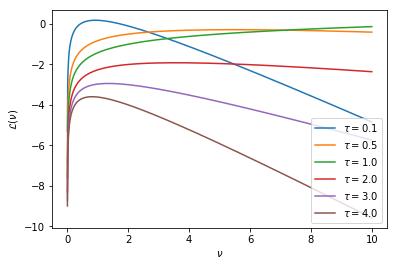

In [1]:
import numpy as np
from scipy.special import gammaln
import matplotlib.pyplot as plt
%matplotlib inline

nus = np.linspace(1e-3, 10, 1000)
elbo = lambda nu, tau, logtau: nu/2 * np.log(nu / 2) - gammaln(nu/2) \
                               + (nu/2 - 1) * logtau - (nu/2) * tau

for tau in [.1, .5, 1, 2, 3, 4]:
    logtau = np.log(tau)
    plt.plot(nus, elbo(nus, tau, logtau), label="$\\tau={:.1f}$".format(tau))
    
plt.xlabel("$\\nu$")
plt.ylabel("$\\mathcal{L}(\\nu)$")
plt.legend(loc="lower right")

## Approximate M-step with generalized Newton's method
Minka [1] suggests a generalized version of Newton's method for optimizing this scalar function.  The following notes are adapted from his manuscript.  He uses a local approximation of the form,

$$
\begin{align*}
g(\nu) &= k + a \log(\nu) + b \nu,
\end{align*}
$$
which has derivatives,
$$
\begin{align*}
g'(\nu) &= \frac{a}{\nu} + b \\
g''(\nu) &= -\frac{a}{\nu^2}
\end{align*}
$$

As in Newton's method, we will locally approximate $\mathcal{L}(\nu)$ with $g(\nu)$ by matching their derivatives at a point $\nu_0$.  This yields,

$$
\begin{align*}
a &= -\nu_0^2 \mathcal{L}''(\nu_0) \\
b &= \mathcal{L}'(\nu_0) - \frac{a}{\nu_0} \\
k &= \mathcal{L}(\nu_0) - a \log \nu_0 - b \nu_0
\end{align*}
$$

For $a > 0$ and $b < 0$, this function is maximized at 

$$
\begin{align*}
\nu^* &= -\frac{a}{b} \\
&= \frac{\nu_0^2 \mathcal{L}''(\nu_0)}{\mathcal{L}'(\nu_0) + \nu_0 \mathcal{L}''(\nu_0)},
\end{align*}
$$
or equivalently,
$$
\begin{align*}
\frac{1}{\nu^*} 
&= \frac{\mathcal{L}'(\nu_0)}{\nu_0^2 \mathcal{L}''(\nu_0)} + \frac{1}{\nu_0}.
\end{align*} 
$$

In our case, 
$$
\begin{align*}
\mathcal{L}(\nu) 
&=
\tfrac{\nu}{2} \log \tfrac{\nu}{2} - \log \Gamma(\tfrac{\nu}{2})
+ (\tfrac{\nu}{2} - 1) \overline{\log \tau_n} - \frac{\nu}{2} \overline{\tau_n}\\
\mathcal{L}'(\nu) 
&=
\tfrac{1}{2}(1 + \log \tfrac{\nu}{2}) - \tfrac{1}{2}\psi(\tfrac{\nu}{2})
+ \tfrac{1}{2} \overline{\log \tau_n} - \tfrac{1}{2} \overline{\tau_n} \\
\mathcal{L}''(\nu) 
&=
\tfrac{1}{2\nu} - \tfrac{1}{4}\psi'(\tfrac{\nu}{2})
\end{align*}
$$

Let's plot this approximation alongside the true function.

[1] https://tminka.github.io/papers/minka-newton.pdf

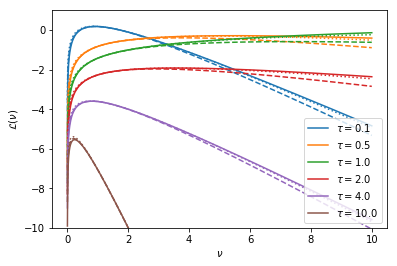

In [2]:
import numpy as np
from scipy.special import gammaln, digamma, polygamma
import matplotlib.pyplot as plt
%matplotlib inline

nus = np.linspace(1e-3, 10, 1000)
elbo = lambda nu, tau, logtau: \
    nu/2 * np.log(nu / 2) - gammaln(nu/2) + (nu/2 - 1) * logtau - (nu/2) * tau

delbo = lambda nu, tau, logtau: \
    1/2 * (1 + np.log(nu/2)) - 1/2 * digamma(nu/2) + 1/2 * logtau - 1/2 * tau
    
ddelbo = lambda nu, tau, logtau: \
    1/(2 * nu) - 1/4 * polygamma(1, nu/2)
    
def approx(nu, tau, logtau, nu0):
    a = -nu0**2 * ddelbo(nu0, tau, logtau)
    b = delbo(nu0, tau, logtau) - a / nu0
    k = elbo(nu0, tau, logtau) - a * np.log(nu0) - b * nu0
    
    # Check the concavity requirements are met
    assert a > 0
    assert b < 0
    
    return k + a * np.log(nu) + b * nu
    
for tau in [.1, .5, 1, 2, 4, 10]:
    logtau = np.log(tau)
    l1 = plt.plot(nus, elbo(nus, tau, logtau), label="$\\tau={:.1f}$".format(tau))[0]
    plt.plot(nus, approx(nus, tau, logtau, 1), ls='--', color=l1.get_color())
    plt.plot(nus, approx(nus, tau, logtau, 2), ls=':', color=l1.get_color())
    
plt.xlabel("$\\nu$")
plt.ylabel("$\\mathcal{L}(\\nu)$")
plt.ylim(-10, 1)
plt.legend(loc="lower right")

In [5]:
# Now implement the fixed point iteratinos
def m_step_nu(tau, logtau, nu0=1, max_iter=10, nu_min=1e-3, nu_max=10, tol=1e-8):
    dnu = np.inf
    for itr in range(max_iter):
        if abs(dnu) < tol:
            print("Tolerance threshold reached in {} iterations.".format(itr))
            break
            
        if nu0 < nu_min or nu0 > nu_max:
            print("Fixed point grew beyond bounds.")
            return np.clip(nu0, nu_min, nu_max)
        
        # Perform the Newton update
        a = -nu0**2 * ddelbo(nu0, tau, logtau)
        b = delbo(nu0, tau, logtau) - a / nu0
        nu = -a / b
        dnu = nu - nu0
        nu0 = nu
    return nu

tau =  0.1
Tolerance threshold reached in 4 iterations.
tau =  0.5
Tolerance threshold reached in 5 iterations.
tau =  1
Fixed point grew beyond bounds.
tau =  2
Tolerance threshold reached in 5 iterations.
tau =  4
Tolerance threshold reached in 4 iterations.
tau =  10
Tolerance threshold reached in 4 iterations.


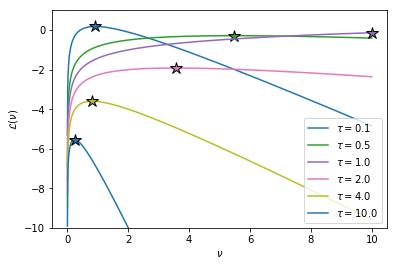

In [6]:
for tau in [.1, .5, 1, 2, 4, 10]:
    print("tau = ", tau)
    logtau = np.log(tau)
    nustar = m_step_nu(tau, logtau)
    l1 = plt.plot(nus, elbo(nus, tau, logtau), label="$\\tau={:.1f}$".format(tau))[0]
    plt.plot(nustar, elbo(nustar, tau, logtau), '*', ms=12, mfc=l1.get_color(), mec='k')
    
plt.xlabel("$\\nu$")
plt.ylabel("$\\mathcal{L}(\\nu)$")
plt.ylim(-10, 1)
plt.legend(loc="lower right")